In [93]:
from lime import lime_image
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [2]:
model = tf.keras.models.load_model('../saved_model.h5')

2022-05-12 22:01:39.599506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 22:01:39.599617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [70]:
target = [
    'beagle', 'cocker_spaniel',
    'maltese', 'pomeranian', 'poodle',
    'samoyed', 'shih_tzu', 'white_terrier']

In [71]:
def img_preprocess(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img = np.array(img)
    img = img / 255
    return img

In [112]:
def explain_image(img_path):
    img = img_preprocess(img_path)
    explainer = lime_image.LimeImageExplainer()

    # 이미지를 슈퍼픽셀로 분할하는 알고리즘 설정
    # quickshift, slic, felzenswalb 등이 존재
    segmenter = SegmentationAlgorithm('slic',
                                    n_segments=100,  # 이미지 분할 조각 개수
                                    compactnes=1,  # 유사한 파트를 합치는 함수
                                    sigma=1)  # 스무딩 역할: 0과 1사이의 float

    explanation = explainer.explain_instance(img,
                                            classifier_fn=model.predict,  # 10개 class 확률 반환
                                            top_labels=5,  # 확률 기준 1~5위
                                            num_samples=1000,  # sample space
                                            segmentation_fn=segmenter)  # 분할 알고리즘                                            
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    plt.show()

    np_img = np.array([img])
    pred = model.predict(np_img)
    pred_idx = np.argmax(pred)
    print(f'This image is {pred[0][pred_idx] * 100}% {target[pred_idx]}')


100%|██████████| 1000/1000 [00:05<00:00, 187.19it/s]


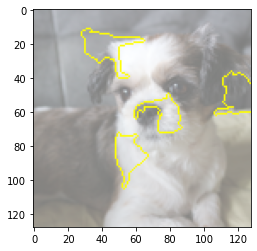

This image is 28.04647386074066% shih_tzu


In [114]:
img_path = '../jjang.jpeg'
explain_image(img_path)

100%|██████████| 1000/1000 [00:05<00:00, 189.95it/s]


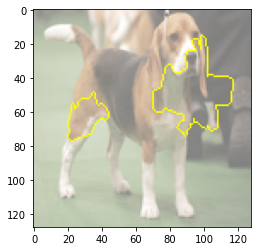

This image is 61.89185976982117% beagle


In [113]:
img_path = '../beagle.jpeg'
explain_image(img_path)
